This notebook, by [felipe.alonso@urjc.es](mailto:felipe.alonso@urjc.es)

In this notebook we will analyze feature selection and PCA techniques in toy examples for understand their fundamentals.

## Table of Contents

1. [Feature Selection](#feature_selection)
 1. [Filter methods](#filter_methods)
    1. [Regression](#filter_regression)
    2. [Classification](#filter_classification)
 2. [Wrapper methods](#wrapper_methods)  
2. [Feature extraction / dimensionality reduction](#feature_extraction)
 1. [PCA](#pca)
3. [Assignment Lab 5](#assignment)

---
## Import libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt

---
<a id='feature_selection'></a>
# 1. Feature Selection

The aim of feature selection is to select the optimum subset of features/variables in order to reduce the dimensionality of the dataset (and thus mitigating the potential overfitting) and improve interpretability.

<a id='filter_methods'></a>
## 1.A Filter methods 

Filter methods rank the input features according to a predefined relevance score. The following are examples of filters for regression and classification problems

<a id='filter_regression'></a>
### Regression problems

Let's analyze [filter methods]((https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)) for regression ([f_regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression), [mutual_info_regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression)) using a simple example:

<div class="alert alert-block alert-info">
<b>Example 1</b>

Let $x_1, x_2,x_3$ be random variables uniformly distributed within the interval $[0,1]$. Target variable $y$ depends on these variables, as follows

$$y = x_1 + \sin{(6\pi x_2)} + 0.1\mathcal{N}(0, 1),$$

Specifically:

* $y$ depends linearly on $x_1$
* $y$ non linear dependency on $x_2$
* $y$ does not depend on $x_3$

therefore, $x_3$ is **irrelevant** for $y$. 

*Note: this example extracted from [here](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py)*
</div>

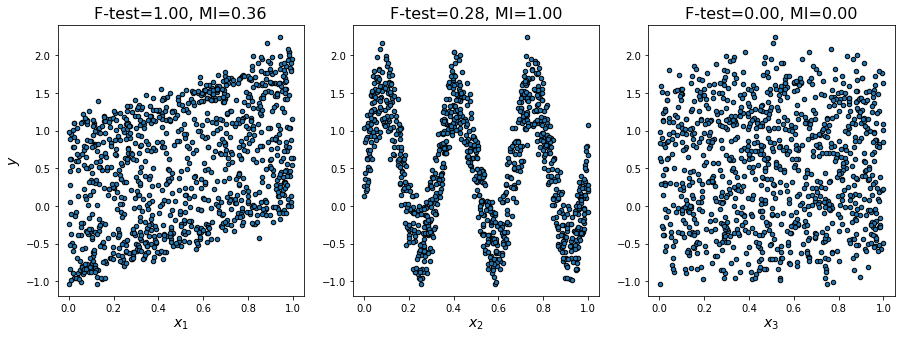

In [2]:
from src.filter_methods import example_one

x1, x2, x3, y = example_one()

<a id='filter_classification'></a>
### Classification problems

Let's define the following classification problems:

<div class="alert alert-block alert-info">
<b>Example 2</b>: linearly separable problem.
    
Let $\{\mathbf{x}_1, \mathbf{x}_2,\ldots, \mathbf{x}_5\}$ be a set of random variables, such that
    
- $\mathbf{x}_1 = z+ \mathcal{N}(0,\sigma_1), \quad z \in \{-\mu,+\mu\}$ 
- $\mathbf{x}_2 = -3\mathbf{x}_1 + \mathcal{N}(0,\sigma_2)$
- $\mathbf{x}_3 = \mathcal{N}(0,2)$
- $\mathbf{x}_4 = \mathcal{N}(0,1)$
        
</div>

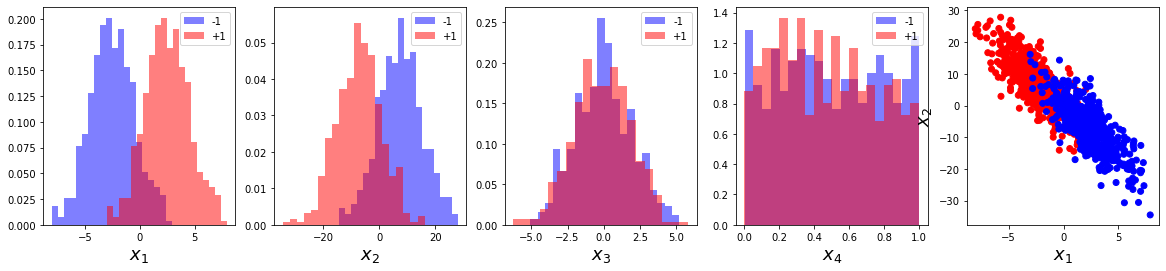

In [3]:
from src.filter_methods import example_two

X, y = example_two(mu = 2.5, sigma_1 = 2, sigma_2 = 5)

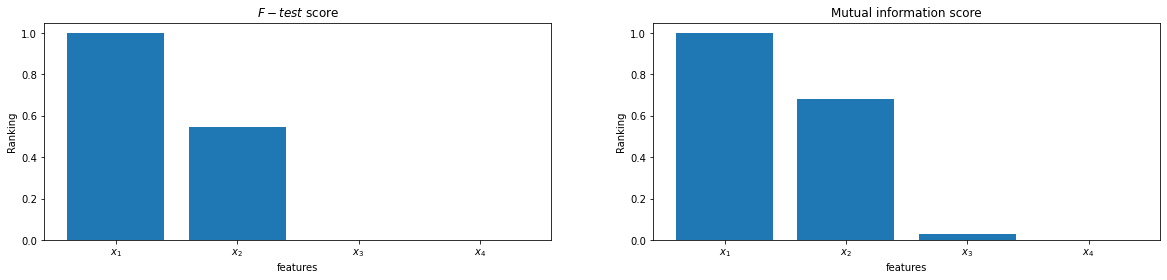

In [4]:
from src.filter_methods import filter_methods_classification

filter_methods_classification(X, y, feat_names = ['$x_1$','$x_2$','$x_3$','$x_4$'])

<div class="alert alert-block alert-info">
<b>Example 3</b>: Non-linear separable problem.
    
Let $\{\mathbf{x}_1, \mathbf{x}_2,\ldots, \mathbf{x}_{24}\}$ be a set of random variables, such that
    
- $\mathbf{x}_1$ and $\mathbf{x}_2$ define an XOR classification problem 
- $\mathbf{x}_3 = 3(\mathbf{x}_1+\mathbf{x}_2)+ \mathcal{N}(0,2)$
- $\mathbf{x}_4 = 2\sqrt{\mathbf{x}_1+\mathbf{x}_2} + \mathcal{N}(0,2)$
- $\mathbf{x}_i = \mathcal{N}(0,4),\quad\forall i=5,\ldots,20$    
    
</div>

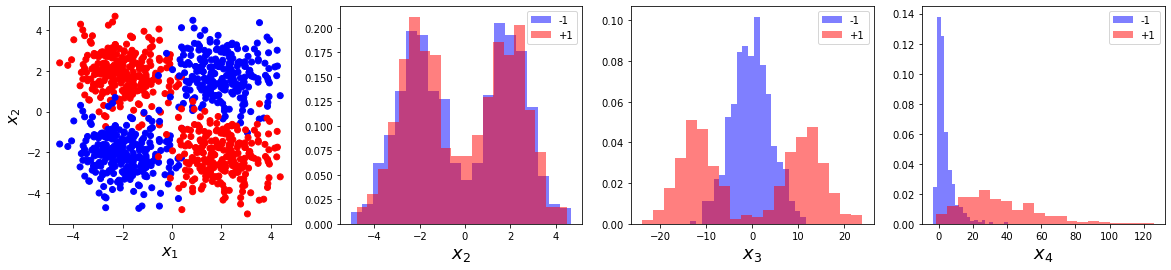

In [5]:
from src.filter_methods import example_three

X, y = example_three(mu=2, sigma=1)

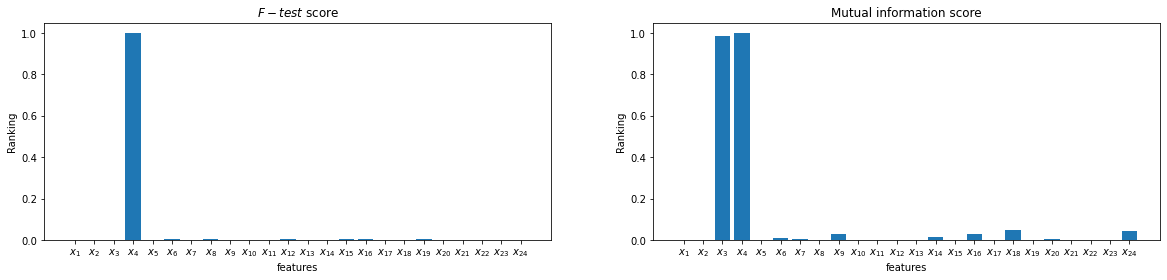

In [6]:
feat_names = ['$x_{'+ str(i+1) + '}$' for i in range(24)]
filter_methods_classification(X, y, feat_names = feat_names)

<div class="alert alert-block alert-info">
<b>Example 4</b>: Real classification problem

Apply filter methods to Pima Indian Diabetes dataset
    
</div>

In [7]:
from src.ddbb import load_pima_indian
X, y = load_pima_indian('./data/pima_indian_diabetes.csv')

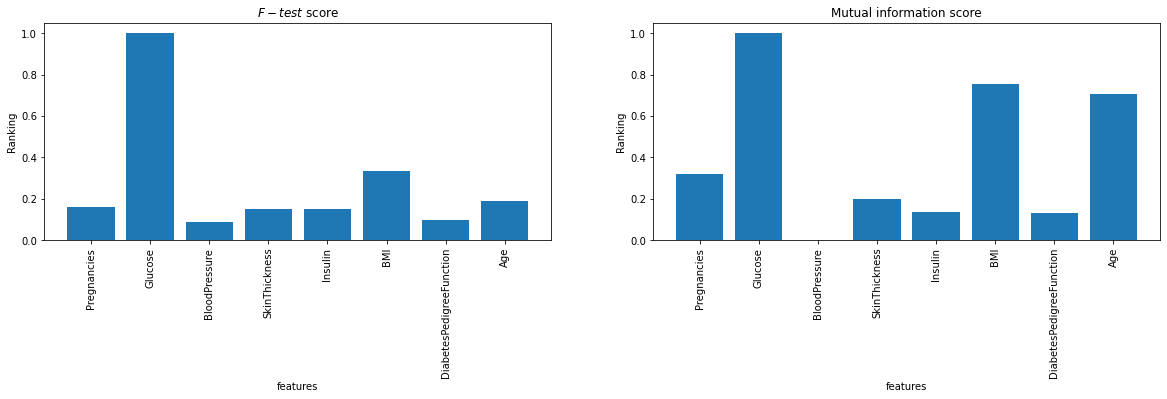

In [8]:
filter_methods_classification(X.values, y.values, feat_names = X.columns, rotation=True)

Now, let's fit a KNN algorithm on a selection of features ... ok, but do it well!!

### An extended feature selection method among practitioners

Could be considered also as an *embbeded* technique.

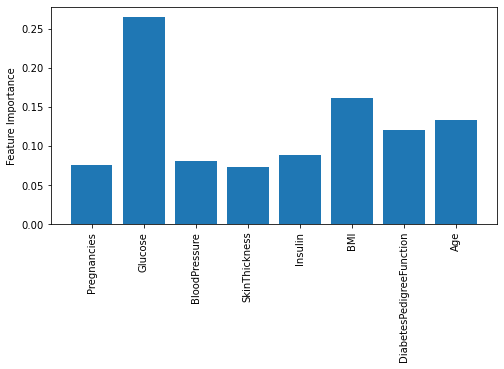

Index(['Glucose', 'BMI'], dtype='object')

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X, y)

plt.figure(figsize=(8,4))
plt.bar(range(X.shape[1]),clf.feature_importances_,  align="center")
plt.xticks(range(X.shape[1]),X.columns, rotation = 90)
plt.ylabel('Feature Importance')
plt.show()

# do it automatically
sel = SelectFromModel(clf, threshold=0.15).fit(X,y)
X.columns[sel.get_support()]

<a id='wrapper_methods'></a>
## 1.B Wrapper methods

Wrappers utilize a machine learning algorithm of interest as a **black box** to score subsets of variables according to their predictive power. When estimating the number of selected features the normally use **backward/forward** procedures together with **cross-validation** techniques to assess the performance of each subset. 

### The wrong and right way to do cross-validation

This example, based on section *7.10.2 The Wrong and Right Way to Do Cross-validation* from the book
"The Elements of Statistical Learning". Hastie, Tibshirani, Friedman

Error rate (%): 3.5719999999999974


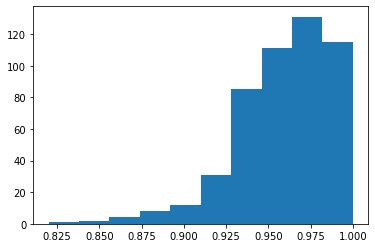

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif

# This is the WRONG way
np.random.seed(0)
score = []

for i in range(500): # This is run for a number of experiments: Montecarlo simulation
    
    # Create toy example: N x D = 50 x 500 !
    N = 50
    X = np.random.randn(N, 5000) # predictors are random variables!!
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    
    # Note here, the ranking and selection is performed outside the CV loop
    # therefore, the selection used all samples, but should use only train samples
    f_test, _ = f_classif(X, y)
    f_test /= np.max(f_test)
    
    ranking = np.argsort(f_test)[::-1] 
    selected = ranking[0:50]
    Xs = X[:,selected]
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(Xs):
        knn.fit(Xs[train],y[train])
        accuracy = knn.score(Xs[validation],y[validation])
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

Error rate (%): 52.664


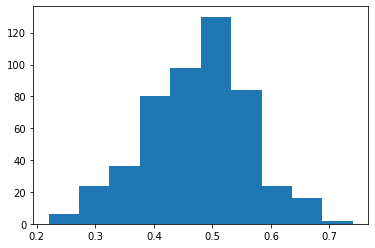

In [11]:
# This is the RIGHT way

np.random.seed(0)
score = []

for i in range(500): # This runs for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors, again random variables
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(X):
        
        # Note here, the ranking and selection is performed inside the CV loop
        f_test, _ = f_classif(X[train,:], y[train])
        f_test /= np.max(f_test)
        ranking = np.argsort(f_test)[::-1] 
        selected = ranking[0:50]
        
        Xs = X[:,selected]
        
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

<div class="alert alert-block alert-info">
<b>Example 5</b>: Backward feature selection 

Implement a backward feature selection algorithm to determine the optimum number of features to address the Pima Indian Diabetes classification problem
    
</div>

You will need:

1. A classification algorithm:
    1. Decision tree with `max_depth=3`
2. A ranking criterion:
    1. `f_classif`
    2. `feature_importance` from the trained decision tree

In [12]:
from src.ddbb import load_pima_indian
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = load_pima_indian('./data/pima_indian_diabetes.csv')
feat_names = X.columns

# Separate in train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, random_state=2)

# scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train data shape:', X_train_scaled.shape)
print('Test  data shape:', X_test_scaled.shape)

Train data shape: (537, 8)
Test  data shape: (231, 8)


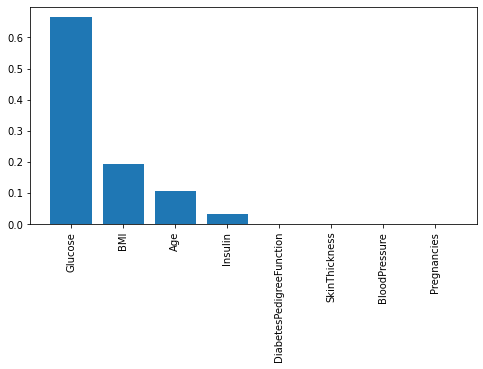

In [13]:
from sklearn.tree import DecisionTreeClassifier

# train a tree
dt = DecisionTreeClassifier(max_depth=3, random_state=2).fit(X_train_scaled,y_train)

# get the importance
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

# do the plotting
plt.figure(figsize=(8, 4))
plt.bar(range(X_train_scaled.shape[1]), importances[indices],align="center")
plt.xticks(range(X_train_scaled.shape[1]),feat_names[indices], rotation=90)
plt.show()

# features 1 error 0.37232606438213917 +/- 0.029693410969644233
# features 2 error 0.36860505365178264 +/- 0.02770473883640756
# features 3 error 0.379785392869505 +/- 0.02631364794507943
# features 4 error 0.36675320179993076 +/- 0.02903995300742885
# features 5 error 0.36114572516441684 +/- 0.030977141092773535
# features 6 error 0.35927656628591215 +/- 0.03210835482144442
# features 7 error 0.36114572516441684 +/- 0.030977141092773535
# features 8 error 0.3648840429214261 +/- 0.029423961000323365


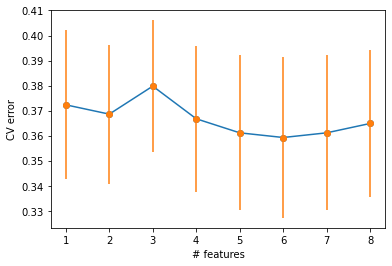

In [14]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif

N, D = X_train_scaled.shape

dt = DecisionTreeClassifier(max_depth=3, random_state=2)
kf = KFold(n_splits=5, shuffle = True, random_state=2)

cv_error = []
cv_std = []

for n in range(D,0,-1):
        
    error_i = []
    
    for train, validation in kf.split(X_train_scaled):
        
        #-- ranking: two options
        
        # option 1: f-test
        f_test, _ = f_classif(X_train_scaled[train], y_train[train])
        f_test /= np.max(f_test)   
        ranking = np.argsort(f_test)[::-1] 
        
        # option 2: feature importance
        ranking = dt.fit(X_train_scaled[train],y_train[train]).feature_importances_
        
        #-- selection
        indices = np.argsort(ranking)[::-1] 
        selected = indices[0:(D-n+1)]
        Xs = X_train_scaled[:,selected]
        
        #-- fit on selected features
        dt.fit(Xs[train],y[train])
        error = 1.0 - dt.score(Xs[validation],y[validation])
        error_i.append(error) 
        
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    
    print('# features ' + str(len(selected)) + ' error ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))

plt.plot(range(1,D+1,1),cv_error,'-o')
plt.errorbar(range(1,D+1,1), cv_error, yerr=cv_std, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')
plt.show()

In [15]:
# complete dataset
dt.fit(X_train_scaled,y_train)
print('Completed model score: ' + str(dt.score(X_test_scaled, y_test)))

# fit reduce dataset
selection = 1 # Glucose
dt.fit(X_train_scaled[:,selection].reshape(-1, 1),y_train)
print('Reduced model score: ' + str(dt.score(X_test_scaled[:,selection].reshape(-1, 1), y_test)))

Completed model score: 0.7532467532467533
Reduced model score: 0.7316017316017316


### Other methods for forward/backward feature selection

- Recursive Feature Elimination ([original paper](http://clopinet.com/isabelle/Papers/geneselect.pdf)): select features by recursively considering smaller and smaller sets of features based on `coef_` or `feature_importances_` attributes. In scikit-learn:
    * [feature_selection.RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)
    * [feature_selection.RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)
    
- [Sequential Feature Selector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/), by [mlextend](http://rasbt.github.io/mlxtend/). 

---
<a id='feature_extraction'></a>
# 2. Feature Extraction / dimensionality reduction

We will be working with the life expectancy dataset

In [16]:
from src.ddbb import load_life_expectancy

X, y = load_life_expectancy('./data/Life Expectancy Data.csv')

Predictors:  (2938, 211)
Target:  (2938,)


<a id='pca'></a>
## 2.1 PCA

Let's start first with an easy example

*Note: this example was extracted from [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html). I encourage you to take a depth look at this notebook for understading PCA*

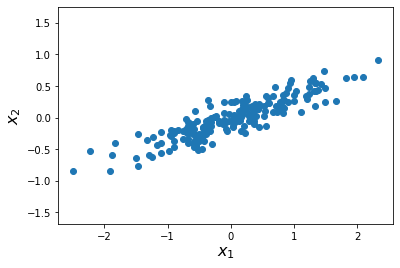

In [17]:
from src.pca_utils import toy_example_pca

X = toy_example_pca()

Recall that PCA transforms (linearly) the original space into a an orthonormal basis (principal components) in which different individual dimensions of the data are linearly uncorrelated:
 - [Principal components](https://en.wikipedia.org/wiki/Principal_component_analysis#Quantitative_finance) are are a sequence of direction vectors, where the $i^{{\text{th}}}$ vector is the direction of a line that best fits the data while being orthogonal to the first  $i-1$ vectors
 - Principal components are eigenvectors of the data's covariance matrix

Components:
 [[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
Variance of each axis (largest eigenvalues): [0.7625315 0.0184779]


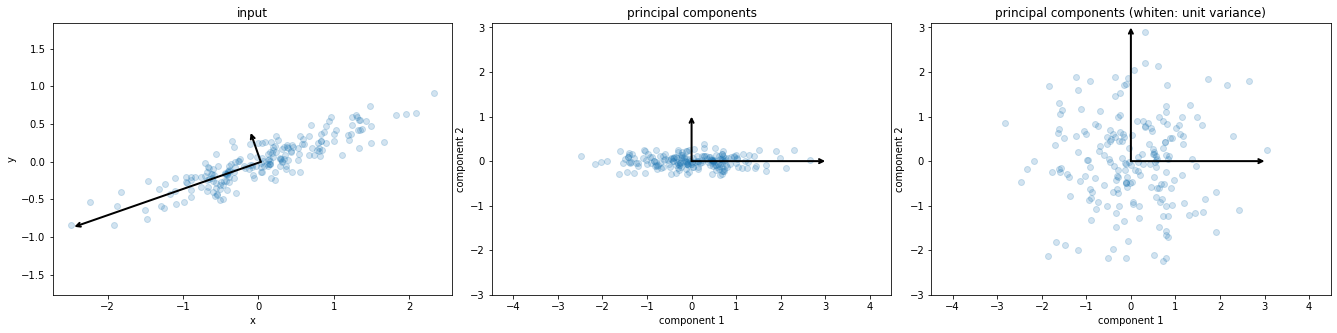

In [18]:
from src.pca_utils import plot_pca_toy_example

pca = plot_pca_toy_example(X)

print('Components:\n', pca.components_)
print('Variance of each axis (largest eigenvalues):', pca.explained_variance_)

### PCA for dimensionality reduction

Project our 2D data into 1D

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1).fit(X)
X_pca = pca.transform(X) # this X is on the transformed space ...

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


To see the transformed data in the original space

This transformation retains the 97.63% of the variance


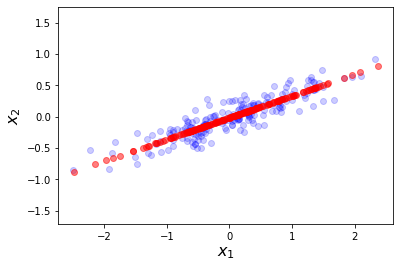

In [20]:
X_new = pca.inverse_transform(X_pca)

plt.scatter(X[:, 0], X[:, 1], c = 'b', alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], c='r', alpha=0.5)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.axis('equal');

print('This transformation retains the {:.2f}% of the variance'.format(100*pca.explained_variance_ratio_[0]))

<div class="alert alert-block alert-info">
<b>Example 6</b>: Apply PCA to life expectancy data

- How many components do we need? 
- Visualize your data
- Train a ML model using the transformed features
</div>

Predictors:  (2938, 211)
Target:  (2938,)


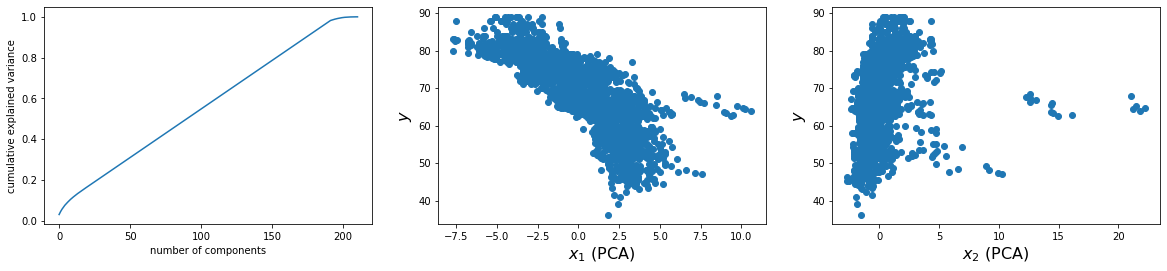

In [21]:
from src.ddbb import load_life_expectancy

X, y = load_life_expectancy('./data/Life Expectancy Data.csv')

# scaling
X_scaled = StandardScaler().fit_transform(X)

# Number of components
pca = PCA().fit(X_scaled)

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# Data visualization (just 2 components)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.subplot(1,3,2)
plt.scatter(X_pca[:,0],y)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(1,3,3)
plt.scatter(X_pca[:,1],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.show()

Even if these two variables look like promising, **do they provide with any interpretation about the data?** You might find of interest the following:

- [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
- [Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)
- [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/) (deep learning)

In [22]:
# Just a quick view, not a proper training
from sklearn.linear_model import LinearRegression

# fit a linear regression model
lr =  LinearRegression().fit(X_pca, y)
print('Train R2 score: {:.3f}'.format(lr.score(X_pca, y)))

Train R2 score: 0.688


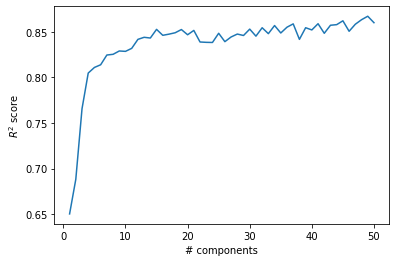

In [23]:
# Just a quick view, not a proper training
r2_score = [] 
n_components_max = 50
for i in range(n_components_max):
    X_pca = PCA(n_components=i+1).fit_transform(X_scaled)
    lr =  LinearRegression().fit(X_pca, y)
    r2_score.append(lr.score(X_pca, y))

plt.plot(np.arange(n_components_max)+1,r2_score)
plt.xlabel('# components')
plt.ylabel('$R^2$ score')
plt.show()

---
<a id='assignment'></a>
# Assignment Lab 5

In [134]:
from src.ddbb import load_life_expectancy
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
def root_mean_squared_error(y_true, y_pred):
    return np.square(mean_squared_error(y_true, y_pred))
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from src.ddbb import load_pima_indian
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [135]:
life_expectancy_df = pd.read_csv('./data/Life Expectancy Data.csv', sep=',', decimal='.')

# do some cleaning to the column's names
def clean_columns(column_name):
    return column_name.strip().lower().replace('  ',' ').replace(' ','_')

life_expectancy_df.columns = [clean_columns(col_name) for col_name in life_expectancy_df.columns]

# rename this column
life_expectancy_df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

#1 Convert to numerical data

life_expectancy_df['status'] = life_expectancy_df['status'].replace(['Developing', 'Developed'],[0, 1])

#2 Converting country to categorical data
life_expectancy_df['country'] = pd.Series(life_expectancy_df['country'],dtype='category')
life_expectancy_df = life_expectancy_df.drop(['status'], axis = 1)
life_expectancy_df['country'] = life_expectancy_df['country'].cat.codes

#3 Fill null values with mean
life_expectancy_df = life_expectancy_df.fillna(life_expectancy_df.mean())

life_expectancy_df.head()

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,0,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,0,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,0,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,0,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,0,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


**1. Using filter methods (select the method you want), train a model using the 10 features on the life expectancy data. What is the performance compared to the complete model (using all features)? Justify your answer**

*For this exercise, we wanted to make several computation, for a better understanding of the Filther Methods selection. For that, we trained 3 models: The first one, using all the features. Secondly, using the 10 selected features based on the highest F-Regression Scores. Lastly, using 10 feature with the highest Mutual Information.*

In [136]:
X = life_expectancy_df.drop(['life_expectancy'], axis = 1)
y = life_expectancy_df['life_expectancy']

x, y = shuffle(X,y, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(x, y)

# Normalize data
X_norm = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [137]:
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train_norm, Y_train)
Y_pred=model.predict(X_test_norm)

print("R2:", model.score(X_test_norm,Y_test))
print("MSE:", mean_squared_error(Y_test, Y_pred, squared=True))
print("RMSE:", root_mean_squared_error(Y_test, Y_pred))
print("MAE:", mean_absolute_error(Y_test, Y_pred))

R2: 0.895834300780741
MSE: 8.670979719893753
RMSE: 75.18588930280875
MAE: 1.8118369825161391


**a) F-Regression**

In [138]:
# generate dataset
X, y = load_life_expectancy('./data/Life Expectancy Data.csv')
#assign column names 
col_list = X.columns
#create a dataframe table
df = pd.DataFrame(X, columns=col_list)

#feature selection using f_regression 
fs = SelectKBest(score_func=f_regression, k=10)
fit = fs.fit(X,y)

#create df for scores
dfscores = pd.DataFrame(fit.scores_)
#create df for column names
dfcolumns = pd.DataFrame(df.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the dataframe columns
featureScores.columns = ['Selected_columns','Score_pearsons'] 

#print 10 best features
print(featureScores.nlargest(10,'Score_pearsons'))  

Predictors:  (2938, 211)
Target:  (2938,)
                   Selected_columns  Score_pearsons
18                        schooling     3072.020016
2                   adult_mortality     2764.044410
17  income_composition_of_resources     2705.081594
7                               bmi     1336.201489
12                         hiv/aids     1316.879388
1                            status      888.349278
11                       diphtheria      857.392617
15             thinness_10-19_years      842.328652
16               thinness_5-9_years      817.241347
9                             polio      794.861308


*As seen above, the 10 features with the highest F-Regression Score can also be obtained from the Pearson Correlation Matrix.*

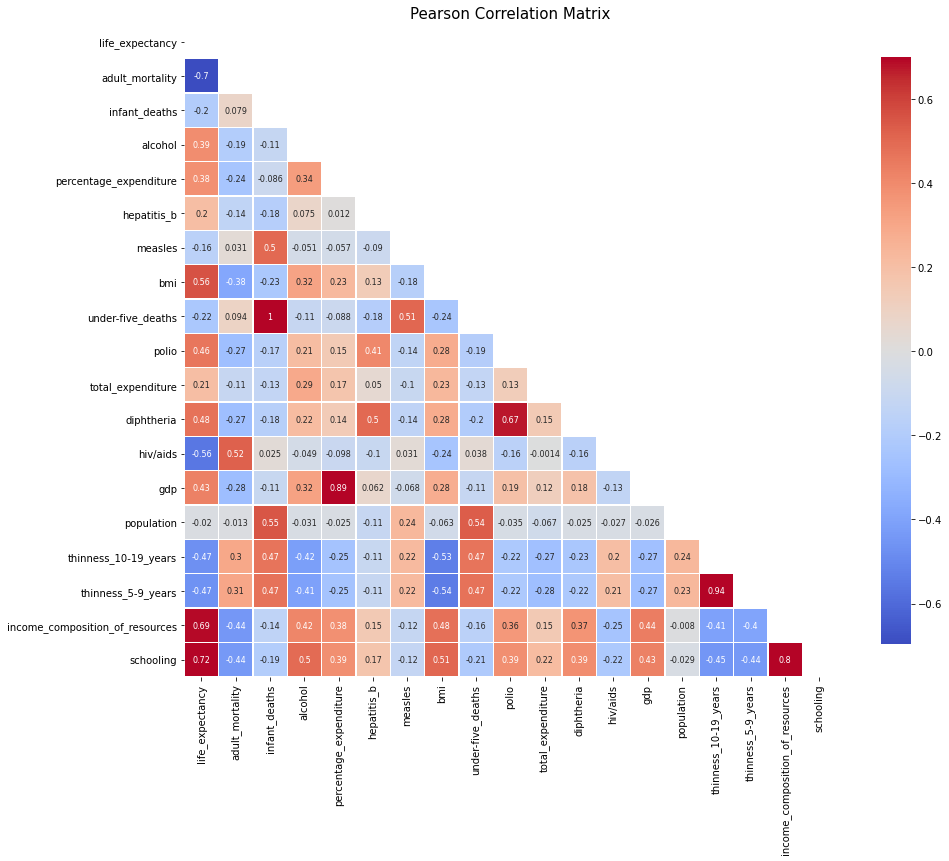

In [139]:
life_expectancy_df = pd.read_csv('./data/Life Expectancy Data.csv', sep=',', decimal='.')

# do some cleaning to the column's names
def clean_columns(column_name):
    return column_name.strip().lower().replace('  ',' ').replace(' ','_')

life_expectancy_df.columns = [clean_columns(col_name) for col_name in life_expectancy_df.columns]

# rename this column
life_expectancy_df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

#1 Convert to numerical data

life_expectancy_df['status'] = life_expectancy_df['status'].replace(['Developing', 'Developed'],[0, 1])

#2 Fill null values with mean

life_expectancy_df = life_expectancy_df.fillna(life_expectancy_df.mean())

continuous_variables = life_expectancy_df.columns[3:]

mask = np.zeros_like(life_expectancy_df[continuous_variables].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=15)

sns.heatmap(life_expectancy_df[continuous_variables].corr(),linewidths=0.25,vmax=0.7,square=True,cmap='coolwarm', #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

*Now, the model will be trained with this 10 features to asses its score.*

In [140]:
fs = SelectKBest(score_func=f_regression, k=10)
fit = fs.fit(X_train_norm, Y_train)
X_train_selected = fs.transform(X_train_norm)
X_test_selected = fs.transform(X_test_norm)

model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train_selected, Y_train)
Y_pred=model.predict(X_test_selected)

print("R2:", model.score(X_test_selected,Y_test))
print("MSE:", mean_squared_error(Y_test, Y_pred, squared=True))
print("RMSE:", root_mean_squared_error(Y_test, Y_pred))
print("MAE:", mean_absolute_error(Y_test, Y_pred))

R2: 0.9189532662472053
MSE: 6.746506671595212
RMSE: 45.5153522698787
MAE: 1.5804193462448735


**b) Mutual information**

In [141]:
X, y = load_life_expectancy('./data/Life Expectancy Data.csv')

#feature selection using mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_regression, k=10)
fit = bestfeatures.fit(X,y)
#create df for scores
dfscores = pd.DataFrame(fit.scores_)
#create df for column names
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the dataframe columns
featureScores.columns = ['Selected_columns','Score_MutualInfo']  
#print 10 best features
print(featureScores.nlargest(10,'Score_MutualInfo')) 

Predictors:  (2938, 211)
Target:  (2938,)
                   Selected_columns  Score_MutualInfo
2                   adult_mortality          1.283954
17  income_composition_of_resources          0.929673
16               thinness_5-9_years          0.775056
15             thinness_10-19_years          0.774284
18                        schooling          0.696904
7                               bmi          0.575173
12                         hiv/aids          0.533027
8                 under-five_deaths          0.425989
13                              gdp          0.356059
3                           alcohol          0.344290


In [142]:
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fit = fs.fit(X_train_norm, Y_train)
X_train_selected = fs.transform(X_train_norm)
X_test_selected = fs.transform(X_test_norm)

model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train_selected, Y_train)
Y_pred=model.predict(X_test_selected)

print("R2:", model.score(X_test_selected,Y_test))
print("MSE:", mean_squared_error(Y_test, Y_pred, squared=True))
print("RMSE:", root_mean_squared_error(Y_test, Y_pred))
print("MAE:", mean_absolute_error(Y_test, Y_pred))

R2: 0.9419081872486036
MSE: 4.835689041926895
RMSE: 23.383888510211854
MAE: 1.2596939704843688


*As seen, We obtained the best results by selecting the most relevant features, either for mutual information or for f_regression.This menas that we are getting read of less relevant and noisy variables that might affect our final result.*

**2. Using a backward selection procedures, how many features would you use for the life expectancy data? Justify your answer.**


In [143]:
life_expectancy_df = pd.read_csv('./data/Life Expectancy Data.csv', sep=',', decimal='.')

# do some cleaning to the column's names
def clean_columns(column_name):
    return column_name.strip().lower().replace('  ',' ').replace(' ','_')

life_expectancy_df.columns = [clean_columns(col_name) for col_name in life_expectancy_df.columns]

# rename this column
life_expectancy_df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

#1 Convert to numerical data

life_expectancy_df['status'] = life_expectancy_df['status'].replace(['Developing', 'Developed'],[0, 1])

#2 Converting country to categorical data
life_expectancy_df['country'] = pd.Series(life_expectancy_df['country'],dtype='category')
life_expectancy_df = life_expectancy_df.drop(['status'], axis = 1)
life_expectancy_df['country'] = life_expectancy_df['country'].cat.codes

#3 Fill null values with mean
life_expectancy_df[life_expectancy_df.values==0].replace(0,np.nan)
life_expectancy_df = life_expectancy_df.fillna(np.mean(life_expectancy_df))


In [144]:
X = life_expectancy_df.drop(['life_expectancy'], axis = 1)
y = life_expectancy_df['life_expectancy']

x, y = shuffle(X,y, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(x, y)

# Normalize data
X_norm = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# features 20 error 9.70679268014632 +/- 1.820891384956955
# features 19 error 9.520382708917888 +/- 1.1131671432230414
# features 18 error 8.86945002998873 +/- 1.8625874656571522
# features 17 error 8.77726540358486 +/- 1.315548158830628
# features 16 error 8.23813725289951 +/- 1.040263597946804
# features 15 error 7.8911844960142 +/- 1.2546609666212398
# features 14 error 7.842457953463696 +/- 0.29665118404490487
# features 13 error 7.195361932698198 +/- 1.1256273731885529
# features 12 error 6.593318124507912 +/- 0.5104271016566833
# features 11 error 6.492678891992886 +/- 0.7599567535131877
# features 10 error 5.769854617466048 +/- 0.6328993114763528
# features 9 error 5.945280584274808 +/- 0.6648652419633958
# features 8 error 5.971161162898812 +/- 1.0302190615257665
# features 7 error 5.7774878839064625 +/- 0.7104313147902646
# features 6 error 6.738738225780152 +/- 1.3029141799140032
# features 5 error 6.105015500002172 +/- 0.7819225687880881
# features 4 error 6.211693018792478

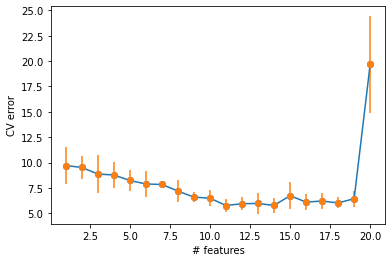

In [145]:
N, D = X_train.shape

model = KNeighborsRegressor(n_neighbors=3)
kf = KFold(n_splits=5 ,shuffle = True)

cv_MSE = []
cv_MSEstd = []
selectedlist = []
milist = []

for n in range(D,0,-1):
        
    MSE_i = []
    
    for train, validation in kf.split(X_train):

        mi= mutual_info_regression(X_train_norm[train], Y_train.iloc[train])
        mi /= np.max(mi)   
        indices = np.argsort(mi)[::-1] 

        selected = indices[0:n]
        Xs = X_train_norm[:,selected]

        model.fit(Xs[train],Y_train.iloc[train])
        y_pred = model.predict(Xs[validation])
        MSE = mean_squared_error(Y_train.iloc[validation], y_pred)
        
        milist.append(mi)
        MSE_i.append(MSE) 
        

    # MEAN OF THE MUTUAL INFORMATION FROM THE 5 CV MODELS TO GET THE SELECTED FEATURES FROM THIS ITERATION (NOT FROM EACH CV MODEL)
    # AND INSERTED ON A LIST TO HAVE THE INFORMATION OF THE FEATURE NAMES WE ARE USING IN THIS STEP.
    mi = np.mean(milist,0)
    mi /= np.max(mi) 
    indices = np.argsort(mi)[::-1] 
    selected = indices[0:n]
    
    selectedlist.append(selected)
    cv_MSE.append(np.mean(MSE_i))
    cv_MSEstd.append(np.std(MSE_i))
    
    #clear_output()
    print('# features ' + str(len(selected)) + ' error ' + str(np.mean(MSE_i)) + ' +/- ' + str(np.std(MSE_i)))

where = cv_MSE.index(min(cv_MSE))

print('Best performance is achieved with ', len(selectedlist[where]), 'features')
plt.plot(range(1,D+1,1),cv_MSE,'-o')
plt.errorbar(range(1,D+1,1), cv_MSE, yerr=cv_MSEstd, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')
plt.show()

**3. For the life expectancy data, analyze the model performance using PCA transformed variables as input features for the model. Compare your results using the original features. To do so:**
    - Choose a ML model
    - Choose a number of `n_components`
    - Assesss model performance, using a chosen regression metric

In all above, justify your selections.



In [146]:
# Loading Database, Train_test splitting and Standarization
X, y = load_life_expectancy('./data/Life Expectancy Data.csv')

X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=0,test_size=0.3)
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

Predictors:  (2938, 211)
Target:  (2938,)


In [147]:
# PCA
pca = PCA(n_components=2).fit(X_train_norm)

# this X is on the transformed space ...
X_pca_train = pca.transform(X_train_norm) 
X_pca_test = pca.transform(X_test_norm)

print("original Xtrain shape:   ", X_train_norm.shape)
print("transformed Xtrain shape:", X_pca_train.shape)
print("original Xtest shape:   ", X_test_norm.shape)
print("transformed Xtest shape:", X_pca_test.shape)

original Xtrain shape:    (2056, 211)
transformed Xtrain shape: (2056, 2)
original Xtest shape:    (882, 211)
transformed Xtest shape: (882, 2)


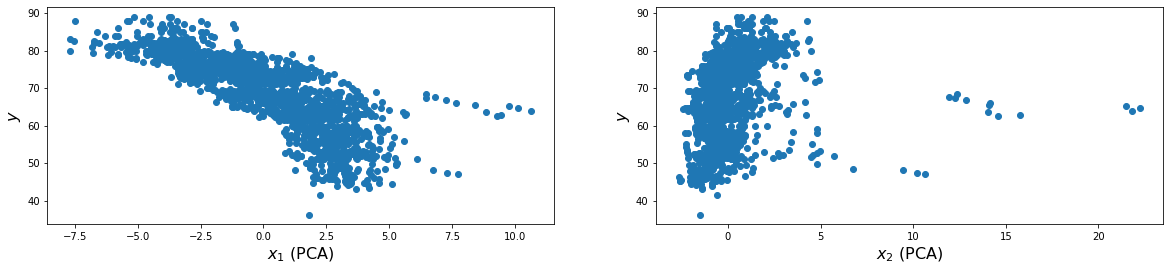

In [148]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
plt.scatter(X_pca_train[:,0],y_train)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(1,2,2)
plt.scatter(X_pca_train[:,1],y_train)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.show()

Once we got our PCA transformed data for **n_components=2** we are going to use it as input of a knn algorithm:

Score 34.158610181798785
Score 23.92135785261137
Score 21.831788091848097
Score 20.75055325246908
Score 20.40328147329126
Score 20.23527636580944
Score 20.13176810347893
Score 20.184330891577957
Score 20.238309975378154
Score 19.904925942928653
Score 19.93398130327019
Score 19.976909301454537
Score 20.183391258445326
Score 20.18423574693657
Score 20.126817745752884


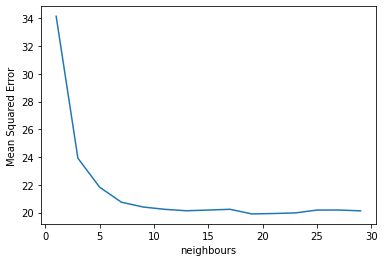

19


In [149]:
k_values = range(1,31,2)

cv_k_scores=[]
for k in k_values:
    kNN = KNeighborsRegressor(n_neighbors=k)
    kNN.fit(X_pca_train,y_train)
    y_pred=kNN.predict(X_pca_test)
    scores=mean_squared_error(y_test,y_pred)
    print('Score',scores)
    cv_k_scores.append(scores.mean())
    
plt.plot(k_values, cv_k_scores)
plt.xlabel('neighbours')
plt.ylabel('Mean Squared Error')
plt.show()

# Select the minimum because we are considering MSE 
print(np.array(k_values)[cv_k_scores.index(np.array(cv_k_scores).min())])

In [150]:
kNN=KNeighborsRegressor(n_neighbors=np.array(k_values)[cv_k_scores.index(np.array(cv_k_scores).min())])
model=kNN.fit(X_pca_train,y_train) 

y_pred=model.predict(X_pca_test)

print(mean_squared_error(y_test, y_pred))

19.904925942928653


Score 4.845853739963582
Score 4.920089063722717
Score 5.528620148895098
Score 6.516914662641265
Score 8.16319482451182
Score 11.781524040682593
Score 18.478603199282144
Score 27.61302154785178
Score 37.68661552630246
Score 45.912200724750974
Score 49.657242948007905
Score 48.62772816074053
Score 46.058550044784965
Score 43.87255926182092
Score 42.22477813963146


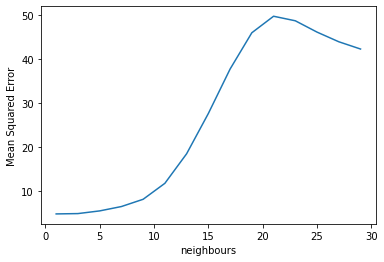

1


In [151]:
k_values = range(1,31,2)

cv_k_scores=[]
for k in k_values:
    kNN = KNeighborsRegressor(n_neighbors=k)
    kNN.fit(X_train_norm,y_train)
    y_pred=kNN.predict(X_test_norm)
    scores=mean_squared_error(y_test,y_pred)
    print('Score',scores)
    cv_k_scores.append(scores.mean())
    
plt.plot(k_values, cv_k_scores)
plt.xlabel('neighbours')
plt.ylabel('Mean Squared Error')
plt.show()

# Select the minimum because we are considering MSE
print(np.array(k_values)[cv_k_scores.index(np.array(cv_k_scores).min())])

In [152]:
kNN=KNeighborsRegressor(n_neighbors=np.array(k_values)[cv_k_scores.index(np.array(cv_k_scores).min())])
model=kNN.fit(X_train_norm,y_train) 

y_pred=model.predict(X_test_norm)

print(mean_squared_error(y_test, y_pred))

4.845853739963582


**4. Visualize the PCA transformation (use `n_components=2`) for the Pima Indian database, using a scatter plot. Colour your transformed samples according to the sample label (example [here](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py)). Is this transformation useful for classification? Justify your answer in terms of performance and interpretability.**

In [153]:
#Load Pima Indian Diabetes database and Standarization

X, y = load_pima_indian('./data/pima_indian_diabetes.csv')

# scaling
X_scaled = StandardScaler().fit_transform(X)

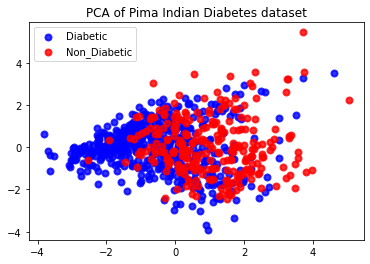

In [154]:
pca = PCA(n_components=2)
X_pca = pca.fit(X_scaled).transform(X_scaled)

colors = ['blue', 'red']
target_names= ['Diabetic','Non_Diabetic']
for color, i, target_name in zip(colors, [0,1,2], target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, alpha=.8, lw=2,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Pima Indian Diabetes dataset')
plt.show()

As we could see above, this transformation would make **classification task harder** since both clusters (Diabetic/Non-Diabetic) are clearly **overlapped** with themselves.